# Packages

### Downloading packages 
#### Select and run just either one of them

In [1]:
!pip3 install requirements -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement requirements (from versions: none)
ERROR: No matching distribution found for requirements


In [2]:
!pip3 install --upgrade pip
!pip3 install mlflow
!pip3 install pandas
!pip3 install sklearn
!pip3 install xgboost
!pip3 install pydotplus

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is 

### Importing libraries

In [3]:
import mlflow
from mlflow.tracking import MlflowClient

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import binascii

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


import xgboost as xgb
import six 
from six import StringIO  
from IPython.display import Image  
import pydotplus


### Reading files and setting variables

In [43]:
path, file = '../../data/', 'dataset.csv'
df = pd.read_csv (os.path.join(path, file), sep = ',')

# Experiments Tracking

## Functions definitions

### Disclaimer

In [5]:
'''
Most of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.
'''

"\nMost of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.\n"

### Log MLFlow experiment

In [6]:
def log_mlflow_experiment(exp_id, name, tags, metrics, nested=False):
    """
    Logs an Mlflow experiment that includes:
        1. Name
        2. Tags
            - Project name
            - Model
        3. Metrics
            - Accuracy score on train and test sets
            - F1 score on train and test sets

    This function allows to create child run experiments, when "nested" is set to True then the resulting experiment
    will be a child run of the current active experiment, otherwise a new parent run is created.

    No return is expected as the result is the logged experiment.

    Parameters:
        exp_id (str): Experiment ID.
        name (str): Experiment name.
        tags (dict): Dictionary with the experiment tags.
        metrics (dict): Dictionary with the performance metrics of the model.
        nested (bool, defaults to False): Flag to indicate if the experiment to create is a child run.
    """
    # Starting experiment
    mlflow.start_run(experiment_id=exp_id, run_name=name, nested=nested)

    # Logging experiment tags and metrics
    mlflow.set_tags(tags)
    mlflow.log_metrics(metrics)

    # Finishing experiment
    mlflow.end_run()

### Calculate performance

In [7]:
def calculate_performance(y_train, y_test, y_train_preds, y_test_preds):
    """
    Calculates the performance metrics of the model on train and test sets. Considered metrics are:
        - Accuracy score
        - F1 score

    Parameters:
        y_train (np.ndarray): Array with the true values of the target variable on the train set.
        y_test (np.ndarray): Array with the true values of the target variable on the test set.
        y_train_preds (np.ndarray): Array with the predicted values of the target variable on the train set.
        y_test_preds (np.ndarray): Array with the predicted values of the target variable on the test set.

    Returns:
        train_acc (float): Accuracy score on the train set
        test_acc (float): Accuracy score on the test set
        train_f1 (float): F1 score on the train set
        test_f1 (float): F1 score on the test set
    """
    # Evaluating train and test predictions with accuracy metric
    train_acc = accuracy_score(y_train, y_train_preds)
    test_acc = accuracy_score(y_test, y_test_preds)

    # Evaluating train and test predictions with F1 Score metric
    train_f1 = f1_score(y_train, y_train_preds)
    test_f1 = f1_score(y_test, y_test_preds)

    return (train_acc, test_acc, train_f1, test_f1)

### Preparing dataset

In [8]:
def preparing_dataset (df, columns = [df.columns[0], df.columns[2]], feature = df.columns[1]):
    # Removing employee identification features
    df.drop(columns=columns, inplace=True)
    
    # Filling null values
    df.fillna(0, inplace = True)
    # df.round(decimals = 3)

    # Separating input features and target variable
    y = df[feature]
    X = df.drop(columns=feature)

    # Encoding target variable
    y = LabelEncoder().fit_transform(y)

    # Splitting dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    return X_train, X_test, y_train, y_test, X, y

## Model definitions

### Feature Importances

In [9]:
 def feature_importances (X_train, X_test, y_train, y_test, X): 
    rfl = RandomForestClassifier()
    rfl.fit(X_train, y_train)
    y_rfl_pred = rfl.predict(X_test)

    importances = rfl.feature_importances_ 

    indices = np.argsort(importances)[::-1]
    feat_labels = X.columns[:]

    for f in range(X_train.shape[1]):
        print("%2d) %-*s %f" % (f + 1, 30, 
                                feat_labels[indices[f]], 
                                importances[indices[f]]))

    from sklearn.tree import DecisionTreeClassifier

    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_clf_pred = clf.predict(X_test)

    print('Accuracy: %.4f' % accuracy_score(y_test, y_clf_pred))
    
    return importances, X_train.columns

### Plot Feature Importances

In [10]:
def plot_feature_importances (importance, names, model_type = 'RANDOM FOREST '):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,15))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

### Plot Decision tree

In [46]:
def decision_tree (X_train, y_train, max_depth = 3, criterion = 'gini'):
    
    X_train.rename(columns={
        '[TF] Use of count & for_each': '[TF] Use of count and for_each',
        '[K8] Services & Networking: Ingress': '[K8] Services and Networking: Ingress', 
        '[K8] Services & Networking: Service':'[K8] Services and Networking: Service',
        }, inplace = True)
    
    X = X_train.columns

    tree = DecisionTreeClassifier(criterion=criterion, # Initialize and fit classifier
        max_depth=max_depth, random_state=1)
    tree.fit(X_train, y_train)

    dot_data = StringIO()
    export_graphviz(tree, 
                    out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names = X, class_names=['Hire', 'No Hire'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    graph.write_png('arbol_{}_{}.png'.format(criterion, max_depth))
    Image(graph.create_png())

### Experiment N°1: The naive model

In [12]:
def experiment_1 (df, y_train, y_test):
    # Generating naive predictions
    y_train_preds = np.zeros(len(y_train))
    y_test_preds = np.zeros(len(y_test))

    # Calculating performance metrics of the model
    train_acc, test_acc, train_f1, test_f1 = calculate_performance(y_train, y_test, y_train_preds, y_test_preds)

    # Creating and starting experiment
    hash = str(binascii.hexlify(os.urandom(3)).decode("utf-8"))
    mlflow_exp = "Exp N°1: Baseline Models - ID {}".format(hash)
    exp_id = mlflow.create_experiment(mlflow_exp)

    # Logging the experiment
    log_mlflow_experiment(
        exp_id,
        "Naive Model",
        {"project": "Caylent - Hiring process", "modelo": "naive"},
        {"train_acc": train_acc, "test_acc": test_acc, "train_f1": train_f1, "test_f1": test_f1}
    )

### Experiment N°2: The delusional model

In [13]:
def experiment_2 (df, y_train, y_test): 
    # Generating naive predictions
    y_train_preds = np.ones(len(y_train))
    y_test_preds = np.ones(len(y_test))

    # Calculating performance metrics of the model
    train_acc, test_acc, train_f1, test_f1 = calculate_performance(y_train, y_test, y_train_preds, y_test_preds)

    # Creating and starting experiment
    hash = str(binascii.hexlify(os.urandom(3)).decode("utf-8"))
    mlflow_exp = "Exp N°2: Baseline Models - ID {}".format(hash)
    exp_id = mlflow.create_experiment(mlflow_exp)

    # Logging the experiment
    log_mlflow_experiment(
        exp_id,
        "Delusional Model",
        {"project": "Caylent - Hiring process", "modelo": "delusional"},
        {"train_acc": train_acc, "test_acc": test_acc, "train_f1": train_f1, "test_f1": test_f1}
    )

### Experiment N°3: KNN model with only numerical features

In [14]:
def experiment_3 (df, X_train, X_test):
    # Filtering numerical features
    new_X_train = X_train.select_dtypes(include="number")
    new_X_test = X_test.select_dtypes(include="number")

    # Defining list of values for the K hyperparameter
    Ks = [1, 2, 3, 4, 5]
    
    # Creating and starting parent experiment
    hash = str(binascii.hexlify(os.urandom(3)).decode("utf-8"))
    mlflow_exp = "Exp N°3: KNN Models - ID {}".format(hash)
    exp_id = mlflow.create_experiment(mlflow_exp)
    mlflow.start_run(experiment_id=exp_id, run_name="KNN Model")

    # Looping over the different values of K
    for k in Ks:
        
        # Defining and training KNN model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(new_X_train, y_train)

        # Generating predictions for train and test sets
        y_train_preds = knn.predict(new_X_train)
        y_test_preds = knn.predict(new_X_test)

        # Calculating performance metrics of the model
        train_acc, test_acc, train_f1, test_f1 = calculate_performance(y_train, y_test, y_train_preds, y_test_preds)

        # Logging the child experiment
        log_mlflow_experiment(
            exp_id,
            "KNN, K={0}".format(k),
            {"project": "Caylent - Hiring process", "modelo": "knn", "k": k},
            {"train_acc": train_acc, "test_acc": test_acc, "train_f1": train_f1, "test_f1": test_f1},
            nested=True
        )

    # Finishing parent experiment
    mlflow.end_run()

### Experiment N°4: XGBoost model

In [15]:
def experiment_4 (X_train, X_test, y_train, y_test, max_rounds = 100):

    # prepare train and test data
    columns = [
    '[Candidate] ID', '[Candidate] Overall',
    'AWS EC2', 'AWS S3: Arch', 'AWS S3: Access', 'AWS S3: Classes', 'AWS S3: DR', 'AWS IAM', 'AWS Networking', 'AWS Net. App. Reliability',
    '[TF] Configuration drifts', '[TF] Use of count  for_each', '[TF] Environments', '[TF] Managing resources', '[TF] Process', '[TF] Secrets and States', '[TF] Sensitive information', '[TF] Best practices', '[TF] Managing values',
    '[K8] Architecture: Auto Scaling', '[K8] Architecture: Control Plane', '[K8] Core Concepts', '[K8] Services  Networking: Ingress', '[K8] Services  Networking: Service', '[K8] Workload Management'
    ]
    # enable auto logging
    mlflow.xgboost.autolog()
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Creating and starting experiment
    hash = str(binascii.hexlify(os.urandom(3)).decode("utf-8"))
    mlflow_exp = "Exp N°4: XGBoost Models - ID {}".format(hash)
    exp_id = mlflow.create_experiment(mlflow_exp)

    with mlflow.start_run():
        params = {
            "objective": "binary:logistic",
            'silent': True,
            'max_depth': 2,
            'subsample': 0.7,
            "eval_metric": "auc",
            "seed": 42,
        }

        # Calculating performance metrics of the model
        evals = [(dtrain, 'train'), (dtest, 'valid')]

        train_acc, test_acc, train_f1, test_f1 = xgb.train(params, dtrain, evals=evals, maximize=True)

        # Logging the child experiment
        log_mlflow_experiment(
            exp_id,
            "XGBoost}",
            {"project": "Caylent - Hiring process", "modelo": "xgboost"},
            {"train_acc": train_acc, "test_acc": test_acc, "train_f1": train_f1, "test_f1": test_f1}
            )
    
    # Finishing parent experiment
    mlflow.end_run()

### Experiment N°5: Random Forest

In [ ]:
def random_forest (X_train, y_train, X_test, y_test):
    
    X_train.rename(columns={
        '[TF] Use of count & for_each': '[TF] Use of count and for_each',
        '[K8] Services & Networking: Ingress': '[K8] Services and Networking: Ingress', 
        '[K8] Services & Networking: Service':'[K8] Services and Networking: Service',
        }, inplace = True)

    X = X_train.columns


    # Random Forest - Initialize and fit classifier
    rfl = RandomForestClassifier(n_estimators=100)
    rfl.fit(X_train, y_train)
    y_test_pred = rfl.predict(X_test)
    y_train_pred = rfl.predict(X_train)

    print('Accuracy: %.4f' % accuracy_score(y_test, y_test_pred))
    print('F1 score: %.4f' % f1_score(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
    print(classification_report(y_test,y_test_pred))


    # Calculating performance metrics of the model
    y_train_pred = rfl.predict(X_train)
    train_acc, test_acc, train_f1, test_f1  = calculate_performance(y_train, y_test, y_train_pred, y_test_pred)

    # Evaluating train and test predictions with accuracy metric
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Evaluating train and test predictions with F1 Score metric
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print ('train_acc: %s' %train_acc)
    print ('test_acc: %s' %test_acc)

    print ('train_f1: %s' %train_f1)
    print ('test_f1: %s' %test_f1)



## Functions executions

### Preparing dataset

In [44]:
X_train, X_test, y_train, y_test, X, y = preparing_dataset (df)

### Feature Importances

In [17]:
importances, names = feature_importances (X_train, X_test, y_train, y_test, X)

 1) [AWS] Networking               0.189873
 2) [AWS] Net. App. Reliability    0.119109
 3) [AWS] S3: Arch                 0.110344
 4) [AWS] S3: Access               0.093564
 5) [AWS] S3: DR                   0.088704
 6) [AWS] EC2                      0.074062
 7) [AWS] IAM                      0.069678
 8) [K8] Workload Management       0.030945
 9) [AWS] S3: Classes              0.029082
10) [K8] Core Concepts             0.023761
11) [K8] Services & Networking: Service 0.021640
12) [TF] Managing values           0.019504
13) [TF] Sensitive information     0.017438
14) [K8] Architecture: Control Plane 0.014584
15) [K8] Services & Networking: Ingress 0.013677
16) [TF] Configuration drifts      0.013477
17) [K8] Architecture: Auto Scaling 0.013166
18) [TF] Managing resources        0.011985
19) [TF] Best practices            0.010886
20) [TF] Environments              0.010584
21) [TF] Secrets and States        0.009263
22) [TF] Process                   0.009103
23) [TF] Use of cou

### Plot Feature Importances

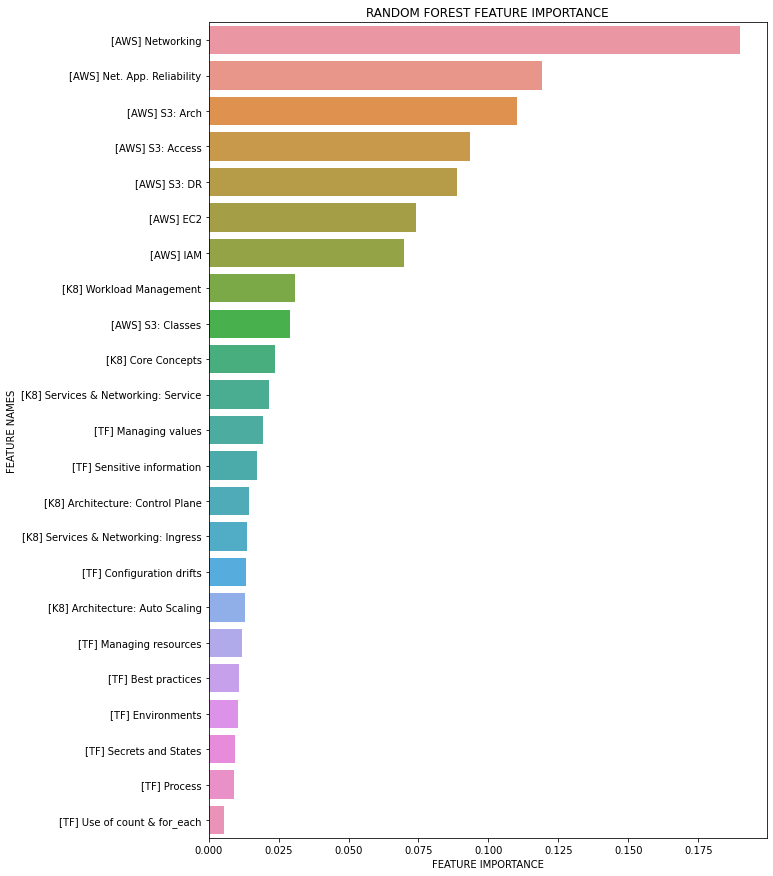

In [18]:
plot_feature_importances ( importances, names )

## Plot Decision tree

In [47]:
# for i in range (3, 7): 
decision_tree (X_train, y_train, 3, 'entropy' )

## Model executions

### Experiment N°1: The naive model

In [ ]:
experiment_1 (df, y_train, y_test) 

### Experiment N°2: The delusional model

In [ ]:
experiment_2 (df, y_train, y_test) 

### Experiment N°3: KNN model with only numerical features

In [ ]:
experiment_3 (df, X_train, X_test) 

/Users/agustin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/agustin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- [K8] Services & Networking: Ingress
- [K8] Services & Networking: Service
- [TF] Use of count & for_each
Feature names seen at fit time, yet now missing:
- [K8] Services and Networking: Ingress
- [K8] Services and Networking: Service
- [TF] Use of count and for_each

  warnings.warn(message, FutureWarning)
/Users/agustin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/agustin/Library/Python/3.9/lib/python

### Experiment N°4: XGBoost model

In [ ]:
# Commented cause breaks kernel
# experiment_4 (X_train, X_test, y_train, y_test)

### Experiment N°5: Random Forest

In [67]:
random_forest (X_train, y_train, X_test, y_test)

Accuracy: 0.8966
F1 score: 0.9091
[[11  2]
 [ 1 15]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        13
           1       0.88      0.94      0.91        16

    accuracy                           0.90        29
   macro avg       0.90      0.89      0.89        29
weighted avg       0.90      0.90      0.90        29

train_acc: 1.0
test_acc: 0.896551724137931
train_f1: 1.0
test_f1: 0.9090909090909091


/Users/agustin/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- [K8] Services & Networking: Ingress
- [K8] Services & Networking: Service
- [TF] Use of count & for_each
Feature names seen at fit time, yet now missing:
- [K8] Services and Networking: Ingress
- [K8] Services and Networking: Service
- [TF] Use of count and for_each

  warnings.warn(message, FutureWarning)


## MLFlow

In [ ]:
run, runs = pd.DataFrame(), pd.DataFrame()
for i in range(0, 8):
    run = mlflow.search_runs(experiment_ids = str(i) )
    runs = runs.append(run)

runs = runs[runs['metrics.train_acc'].notna()]
runs.drop_duplicates(inplace = True)
runs.reset_index(inplace = True)
runs.drop(columns = ['index'], axis = 1 )
runs.to_csv('../../outputs/files/runs.csv', encoding = 'UTF-8')